In [25]:
import os
import librosa
import numpy as np

base = "/content/drive/MyDrive/plant_sounds"  # CHANGE IF NEEDED

features = []

files = []

for f in os.listdir(base):
    if f.endswith(".wav"):
        fp = os.path.join(base,f)
        y,sr = librosa.load(fp, sr=None)
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64)
        mel_db = librosa.power_to_db(mel, ref=np.max)
        mel_db = np.resize(mel_db,(64,64))
        features.append(mel_db.flatten())
        files.append(fp)

features = np.array(features)

print(features.shape)


(1000, 4096)


In [26]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
X_reduced = pca.fit_transform(features)

print(X_reduced.shape)


(1000, 50)


In [27]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_reduced)

clusters[:20]


array([0, 2, 1, 0, 2, 2, 0, 1, 2, 0, 1, 0, 2, 1, 1, 1, 2, 2, 2, 1],
      dtype=int32)

In [28]:
import pandas as pd

df = pd.DataFrame({
    "file": files,
    "cluster": clusters
})

df.to_csv("sound_clusters.csv", index=False)

df.head()


,file,cluster
0,/content/drive/MyDrive/plant_sounds/plant_stre...,0
1,/content/drive/MyDrive/plant_sounds/plant_stre...,2
2,/content/drive/MyDrive/plant_sounds/plant_stre...,1
3,/content/drive/MyDrive/plant_sounds/plant_stre...,0
4,/content/drive/MyDrive/plant_sounds/plant_stre...,2


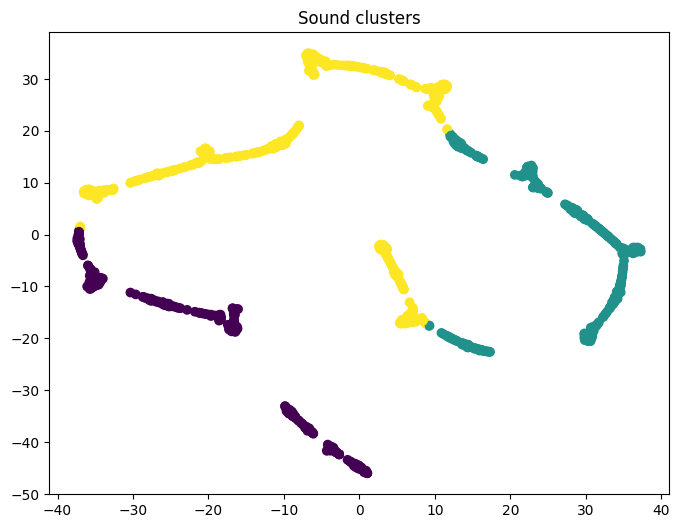

In [29]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

proj = TSNE(n_components=2).fit_transform(X_reduced)

plt.figure(figsize=(8,6))
plt.scatter(proj[:,0], proj[:,1], c=clusters)
plt.title("Sound clusters")
plt.show()


In [30]:
import os
import shutil

cluster_dir = "/content/drive/MyDrive/plant_sounds_clustered"
os.makedirs(cluster_dir, exist_ok=True)

for i in range(3):
    os.makedirs(os.path.join(cluster_dir, f"cluster_{i}"), exist_ok=True)

for fp, c in zip(files, clusters):
    name = os.path.basename(fp)
    shutil.copy(fp, os.path.join(cluster_dir, f"cluster_{c}", name))

print("Done!")


Done!


In [31]:
base = "/content/drive/MyDrive/plant_sounds_clustered"
#healthy
#high_stress
#moderate_stress

In [32]:
X=[]
y=[]

for label in os.listdir(base):
    folder = os.path.join(base,label)
    if os.path.isdir(folder):
        for f in os.listdir(folder):
            file = os.path.join(folder,f)
            feat = extract_melspectrogram(file)
            X.append(feat)
            y.append(label)

X = np.array(X)
y = np.array(y)

print(X.shape, y.shape)


(1000, 128, 128) (1000,)


In [33]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)


In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [35]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

# ===== Dataset Wrapper =====
class PlantSoundDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X).float()
        self.y = torch.tensor(y).long()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx].unsqueeze(0), self.y[idx]

train_ds = PlantSoundDataset(X_train, y_train)
test_ds  = PlantSoundDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=32)


In [36]:
class PlantStressCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, len(le.classes_))   # #classes output
        )

    def forward(self, x):
        return self.net(x)


model = PlantStressCNN()

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [37]:
for epoch in range(25):
    model.train()
    total_loss = 0

    for xb, yb in train_loader:
        pred = model(xb)
        loss = loss_fn(pred, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} | Loss: {total_loss/len(train_loader):.4f}")


Epoch 1 | Loss: 3.4533
Epoch 2 | Loss: 0.0247
Epoch 3 | Loss: 0.0475
Epoch 4 | Loss: 0.0240
Epoch 5 | Loss: 0.0430
Epoch 6 | Loss: 0.0145
Epoch 7 | Loss: 0.0328
Epoch 8 | Loss: 0.0295
Epoch 9 | Loss: 0.0093
Epoch 10 | Loss: 0.0045
Epoch 11 | Loss: 0.0069
Epoch 12 | Loss: 0.0063
Epoch 13 | Loss: 0.0075
Epoch 14 | Loss: 0.0297
Epoch 15 | Loss: 0.0240
Epoch 16 | Loss: 0.0113
Epoch 17 | Loss: 0.0430
Epoch 18 | Loss: 0.0182
Epoch 19 | Loss: 0.0171
Epoch 20 | Loss: 0.0180
Epoch 21 | Loss: 0.0084
Epoch 22 | Loss: 0.0031
Epoch 23 | Loss: 0.0093
Epoch 24 | Loss: 0.0091
Epoch 25 | Loss: 0.0130


In [38]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

model.eval()
preds = []
true = []

with torch.no_grad():
    for xb, yb in test_loader:
        p = model(xb).argmax(1)
        preds.extend(p.tolist())
        true.extend(yb.tolist())

print("Accuracy =", accuracy_score(true, preds))
print(confusion_matrix(true, preds))
print(classification_report(true, preds))


Accuracy = 1.0
[[61  0  0]
 [ 0 53  0]
 [ 0  0 86]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        61
           1       1.00      1.00      1.00        53
           2       1.00      1.00      1.00        86

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [39]:
torch.save(model.state_dict(), "plant_stress_audio_cnn.pth")


In [40]:
import joblib
joblib.dump(le, "label_encoder.pkl")


['label_encoder.pkl']